In [2]:
%matplotlib inline

import numpy as np
import sigpy as sp
import matplotlib.pyplot as plt
from scipy.io import loadmat

plt.style.use('dark_background')
plt.rcParams["savefig.bbox"] = 'tight'

In [3]:
case = "../data/testing/case002"

In [4]:
ref = np.load("%s/ref_2min.npy" % case, mmap_mode="r")
ref = sp.fft(ref.T, axes=(0,))[:, ::-1, :, :]
ref /= np.linalg.norm(ref[0, ...])

In [5]:
deli = np.load("%s/deli_2min.npy" % case, mmap_mode="r")
deli = sp.fft(deli.T, axes=(0,))[:, ::-1, :, :]
deli /= np.linalg.norm(deli[0, ...])

In [6]:
fin = np.load("%s/refine_2min_iters_20.npy" % case, mmap_mode="r")
fin = sp.fft(fin.T, axes=(0,))[:, ::-1, :, :]
fin /= np.linalg.norm(fin[0, ...])

In [7]:
# set up basis and dictionary for quantitative fitting
phi = loadmat("../data/shared/phi.mat")["phi"][:, :5]
phi = phi @ sp.fft(np.eye(phi.shape[-1]), axes=(0,))
mat = loadmat("../data/shared/dictionary.mat")

T1 = mat["T1"].ravel()
T2 = mat["T2"].ravel()
mat = mat["I_b"]
(T2, T1) = np.meshgrid(T2, T1)
T1 = T1.ravel()
T2 = T2.ravel()
mat = phi.conj().T @ np.reshape(mat, (-1, mat.shape[-1])).T
nrm = np.linalg.norm(mat, axis=0)
mat = np.array(mat/nrm[None, :],dtype=np.complex64)

In [8]:
def fit(x, dev, mat):
    dev = sp.Device(dev)
    xp = dev.xp
    with dev:
        mat = sp.to_device(mat, dev)
        x = sp.to_device(x, dev)
        
        x     = xp.abs(mat.conj().T @ x)
        lst_idx = sp.to_device(xp.argmax(x, axis=0), -1)
        
    fit_T1  = [T1[idx] for idx in lst_idx]
    fit_T2  = [T2[idx] for idx in lst_idx]

    return (fit_T1, fit_T2)

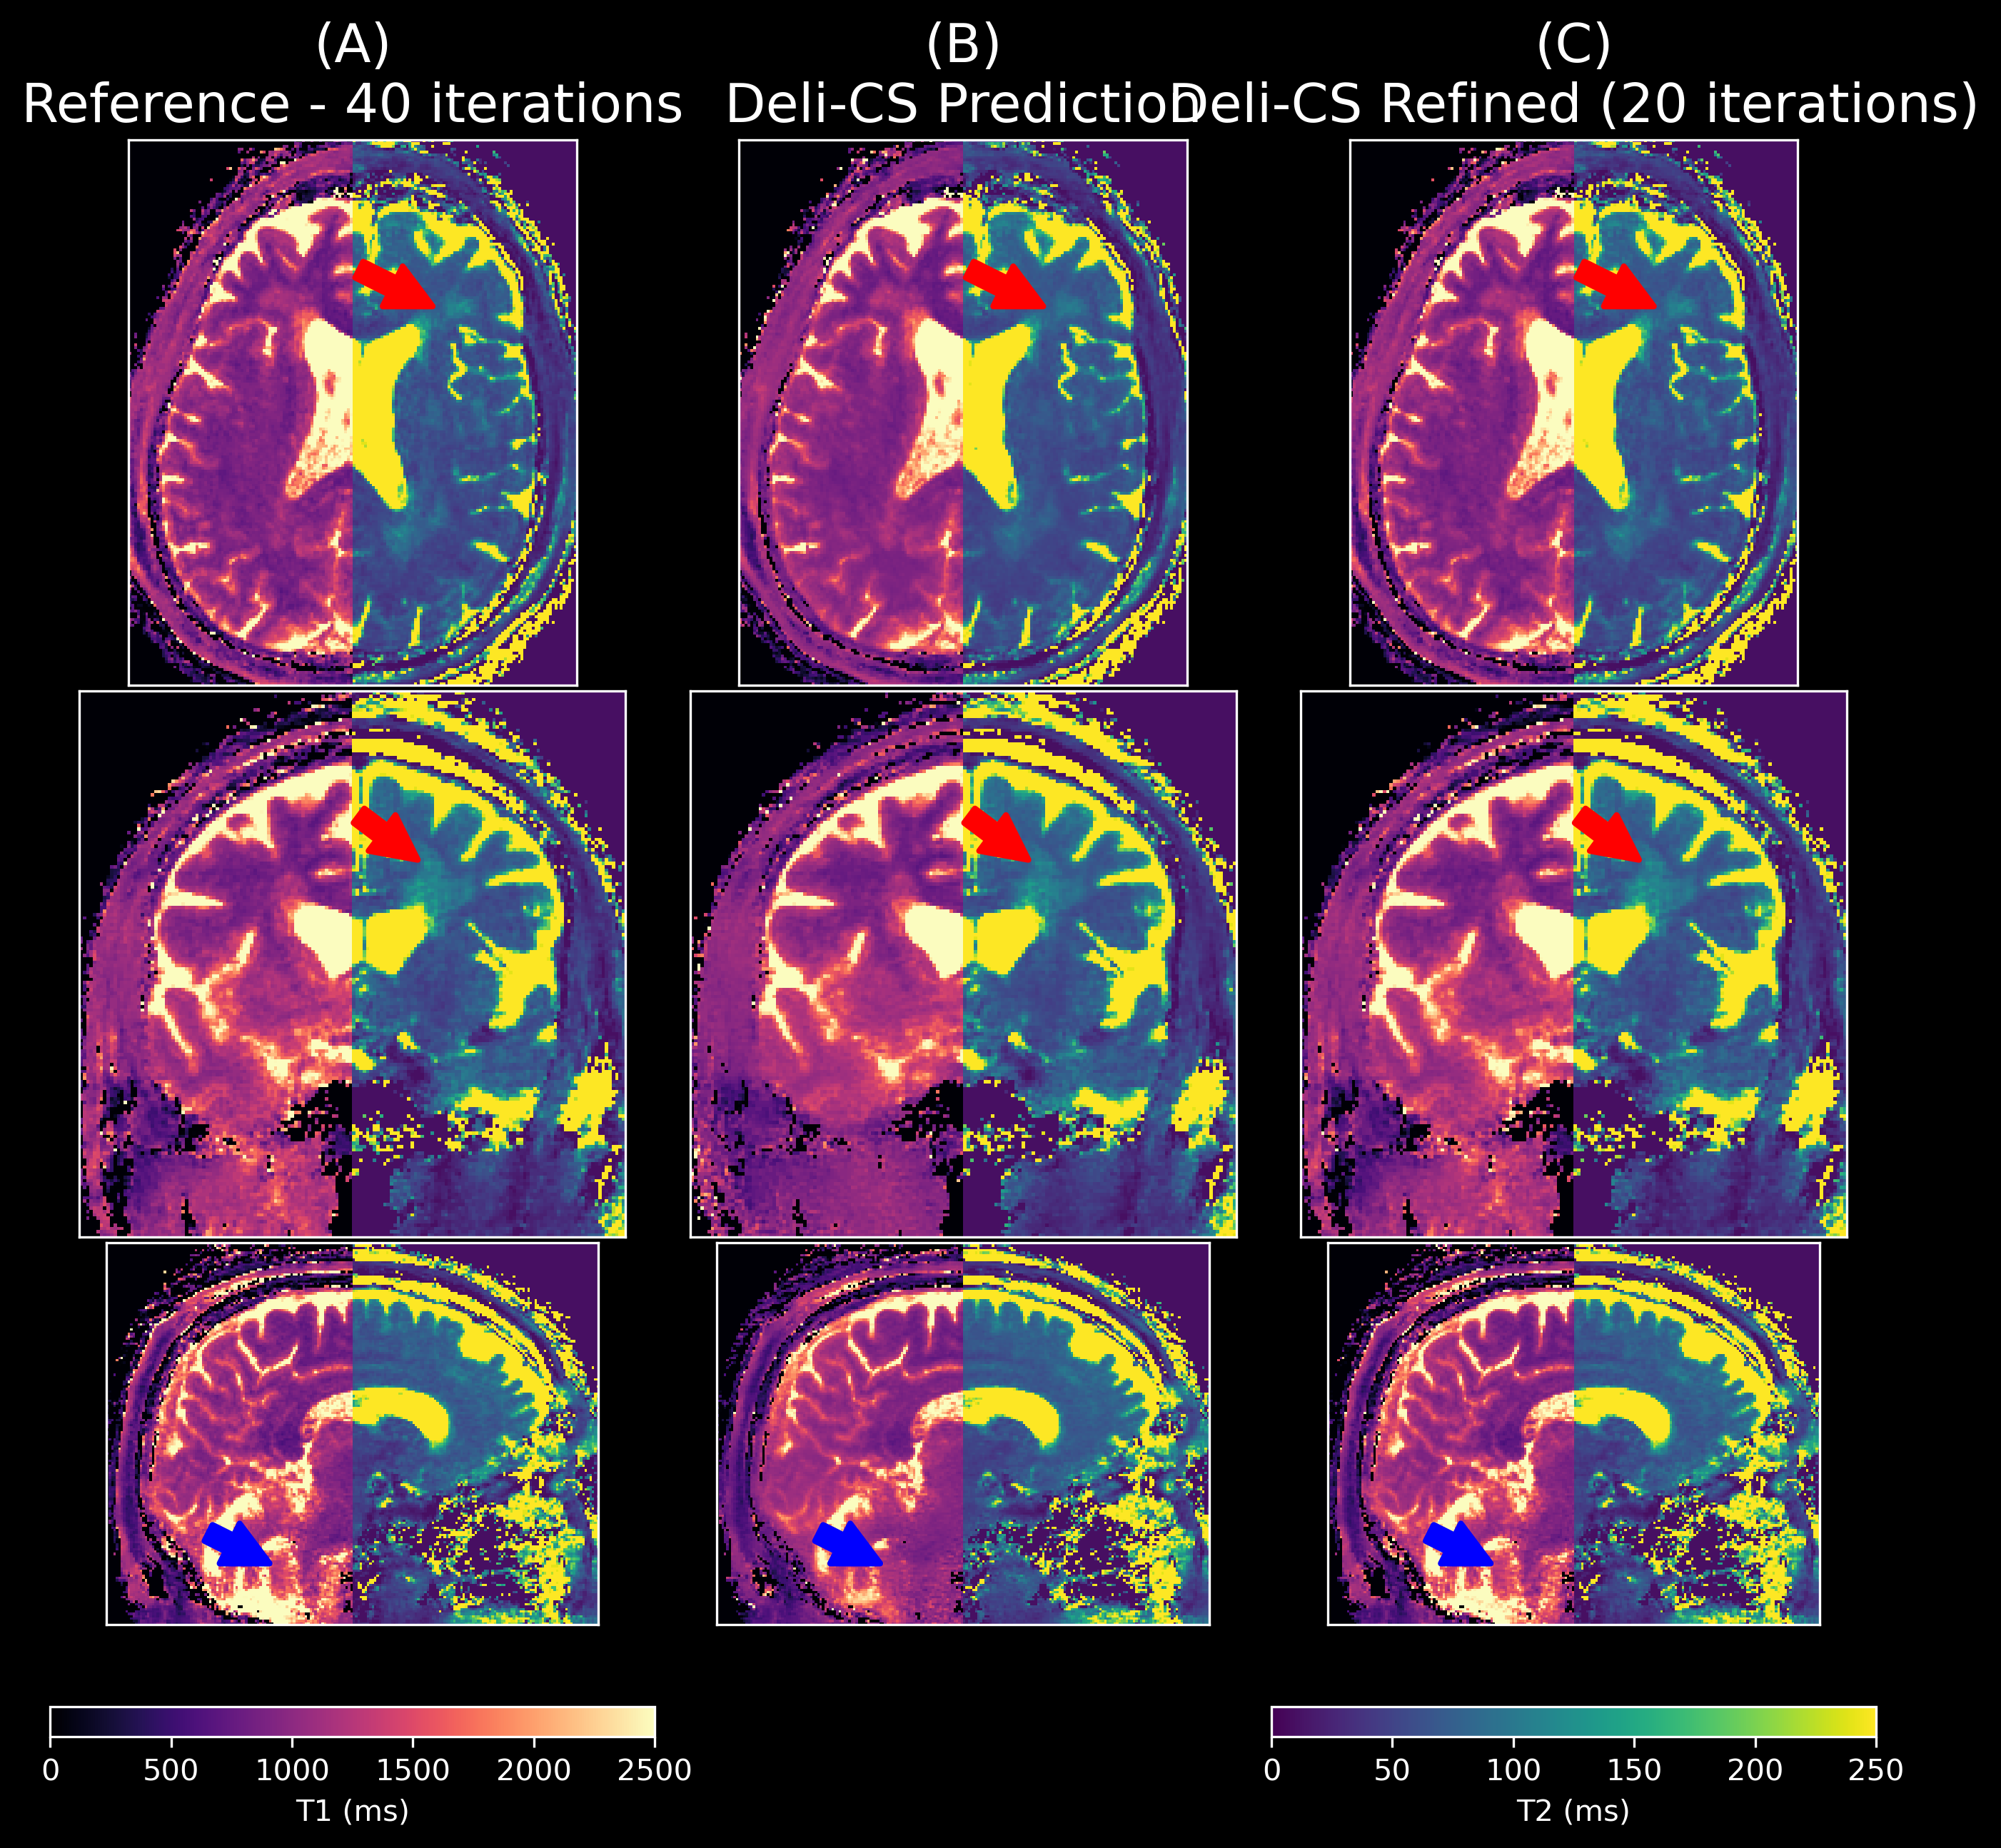

In [17]:
(fig, axs) = plt.subplots(3, 3, figsize=(11, 10), dpi=300)
magn_thresh = 0.00005
msk = ((np.abs(ref[0,...])/np.linalg.norm(ref[0,...])) > magn_thresh)
dev = 0
c = slice(0,5)
vmin = 0
vmax = 2500

idx = (90, slice(None, None, -1), slice(None))
jdx = (slice(None,  -1), 128, slice(None))
kdx = (slice(None,  -1), slice(None),128)

def f(x,ax):
    tmp = sp.ifft(x[(c,) + idx][...,50:245,60:220],axes=(0,))
    tmp1=np.zeros(tmp.shape[1:])
    tmp2=np.zeros(tmp.shape[1:])
    for lin in range(tmp.shape[-1]):
        (tmp1[:,lin],tmp2[:,lin]) = fit(tmp[:,:,lin],  dev, mat)
    msk1 = np.zeros(tmp1.shape)
    msk1[:,:int(tmp1.shape[-1]/2)] = 1
    msk2 = np.zeros(tmp1.shape)
    msk2[:,int(tmp1.shape[-1]/2):] = 1
    data1 = np.ma.masked_array(tmp1,msk2)
    data2 = np.ma.masked_array(tmp2, msk1)
    im1 = ax.imshow(data1, cmap="magma", vmin=vmin, vmax=vmax)
    im2 = ax.imshow(data2, cmap="viridis", vmin=vmin, vmax=vmax/10)
    return (im1,im2)

def g(x,ax):
    tmp = sp.ifft(x[(c,) + jdx][...,20:180,60:220],axes=(0,))
    tmp1=np.zeros(tmp.shape[1:])
    tmp2=np.zeros(tmp.shape[1:])
    for lin in range(tmp.shape[-1]):
        (tmp1[:,lin],tmp2[:,lin]) = fit(tmp[:,:,lin],  dev, mat)
    msk1 = np.zeros(tmp1.shape)
    msk1[:,:int(tmp1.shape[-1]/2)] = 1
    msk2 = np.zeros(tmp1.shape)
    msk2[:,int(tmp1.shape[-1]/2):] = 1
    data1 = np.ma.masked_array(tmp1,msk2)
    data2 = np.ma.masked_array(tmp2, msk1)
    im1 = ax.imshow(data1, cmap="magma", vmin=vmin, vmax=vmax)
    im2 = ax.imshow(data2, cmap="viridis", vmin=vmin, vmax=vmax/10)
    return (im1,im2)

def h(x,ax):
    tmp = sp.ifft(x[(c,) + kdx][...,20:180,0:206],axes=(0,))
    tmp1=np.zeros(tmp.shape[1:])
    tmp2=np.zeros(tmp.shape[1:])
    for lin in range(tmp.shape[-1]):
        (tmp1[:,lin],tmp2[:,lin]) = fit(tmp[:,:,lin],  dev, mat)
    msk1 = np.zeros(tmp1.shape)
    msk1[:,:int(tmp1.shape[-1]/2)] = 1
    msk2 = np.zeros(tmp1.shape)
    msk2[:,int(tmp1.shape[-1]/2):] = 1
    data1 = np.ma.masked_array(tmp1,msk2)
    data2 = np.ma.masked_array(tmp2, msk1)
    im1 = ax.imshow(data1, cmap="magma", vmin=vmin, vmax=vmax)
    im2 = ax.imshow(data2, cmap="viridis", vmin=vmin, vmax=vmax/10)
    return (im1,im2)

f(ref*msk[None,...],axs[0][0])
f(deli*msk[None,...],axs[0][1])
f(fin*msk[None,...],axs[0][2])
g(ref*msk[None,...],axs[1][0])
g(deli*msk[None,...],axs[1][1])
g(fin*msk[None,...],axs[1][2])
h(ref*msk[None,...],axs[2][0])
h(deli*msk[None,...],axs[2][1])
(im1,im2) = h(fin*msk[None,...],axs[2][2])

for ax in axs.ravel():
    ax.set_xticks([])
    ax.set_yticks([])


axs[0][0].set_title("(A)\nReference - 40 iterations",     fontsize=18)
axs[0][1].set_title("(B)\nDeli-CS Prediction",    fontsize=18)
axs[0][2].set_title("(C)\nDeli-CS Refined (20 iterations)",           fontsize=18)

plt.colorbar(im1,ax=axs[2][0], cmap='magma', label='T1 (ms)',orientation="horizontal")
cb = plt.colorbar(im2,ax=axs[2][1], cmap='viridis',label='T2 (ms)',orientation="horizontal")
cb.remove()

plt.colorbar(im2,ax=axs[2][2], cmap='viridis',label='T2 (ms)',orientation="horizontal")

for ii in [0,1,2]:
    ax = axs[2][ii]
    ax.annotate("", xy=(70,135), xytext=(40,120), arrowprops=dict(arrowstyle="simple",color="b",linewidth=2,mutation_scale=30))
    ax = axs[1][ii]
    ax.annotate("", xy=(100,50), xytext=(80,35), arrowprops=dict(arrowstyle="simple",color="r",linewidth=2,mutation_scale=30))
    ax = axs[0][ii]
    ax.annotate("", xy=(110,60), xytext=(80,45), arrowprops=dict(arrowstyle="simple",color="r",linewidth=2,mutation_scale=30))

plt.subplots_adjust(wspace=0.01, hspace=0.01)
plt.savefig('09_quant_block_patient.png')